In [1]:
import requests, json
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from clean_data_funcs import *

# Importing and cleaning data

In [2]:
# base_url = 'https://fantasy.premierleague.com/api/'

# r = requests.get(base_url+'bootstrap-static/').json()

In [3]:
# players = pd.json_normalize(r['elements'])

In [4]:
# players.to_csv('players_dirty250804.csv', index=False)
players = pd.read_csv('players_dirty250804.csv')

In [5]:
players = combine_clean_names(players, 'first_name', 'second_name')
players = players.set_index('full_name')

In [6]:
players_simple = players[['element_type', 'now_cost', 'team', 'team_code', 'total_points', 'team_join_date']]

In [7]:
pos_dict = {1: 'GK',
            2: 'DEF',
            3: 'MID',
            4: 'FWD'}
players_simple['pos'] = players_simple['element_type'].map(pos_dict)

C:\Users\dellis2\AppData\Local\Temp\ipykernel_22384\3515106721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_simple['pos'] = players_simple['element_type'].map(pos_dict)


In [8]:
teams_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/teams.csv'
teams = pd.read_csv(teams_url)
teams = teams.rename(columns={'code': 'team_code', 
                              'name': 'team'})

teamcode_dict = dict(zip(teams['team_code'], teams['team']))
teamcode_dict[56] = 'Sunderland'
teamcode_dict[90] = 'Burnley'
teamcode_dict[2] = 'Leeds'

In [9]:
players_simple['team_name'] = players_simple['team_code'].map(teamcode_dict)

C:\Users\dellis2\AppData\Local\Temp\ipykernel_22384\2271993058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_simple['team_name'] = players_simple['team_code'].map(teamcode_dict)


In [10]:
pl2425_goals = pd.read_csv('pl_2425_goalsbyteam.csv')
pl2425_goals = pl2425_goals.rename(columns={'team':'team_name'})

In [11]:
players_simple2 = players_simple.reset_index(
                        ).merge(pl2425_goals, on='team_name', how='left'
                                ).set_index('full_name')

In [12]:
players_simple2['GF'] = players_simple2['GF'].fillna('37.7') # Filling promoted teams goals scored and conceded with average from last 10 years
players_simple2['GA'] = players_simple2['GA'].fillna('67.16666667')

In [13]:
players_simple3 = players_simple2.drop(['element_type', 'team', 'team_code'], axis=1)

In [14]:
players_simple3.to_csv('cleaned_players.csv')

# Fitting model

In [15]:
players_cleaned = pd.read_csv('cleaned_players.csv', index_col='full_name')

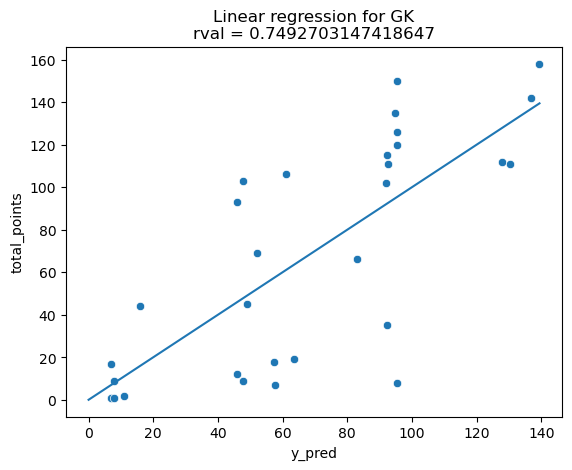

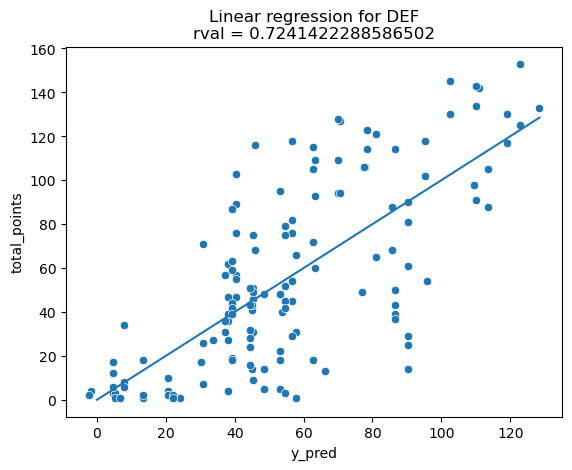

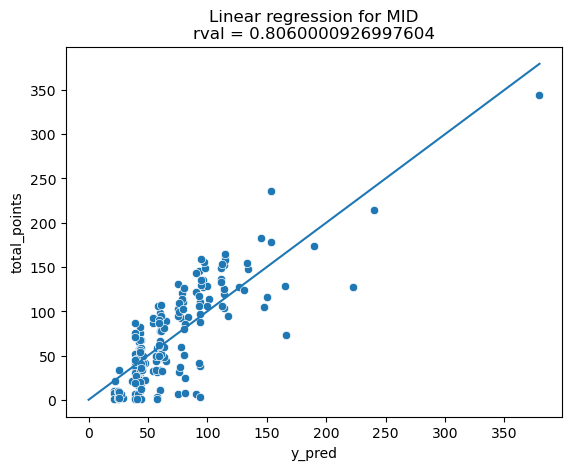

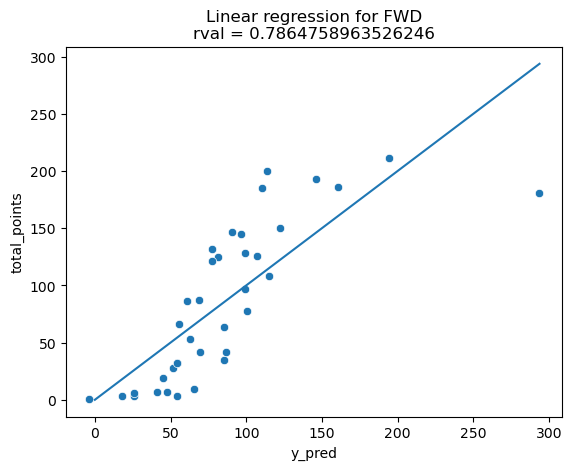

In [16]:
poss = []
checkings = []
predictions = []

for pos in players_cleaned['pos'].unique():
    # print(pos)
    df = players_cleaned.query('pos==@pos')
    X_full = df[['now_cost', 'GF', 'GA']]
    y_full = df['total_points']

    # Training the model on scoring players only
    df2 = df.query('total_points>0')
    X_train = df2[['now_cost', 'GF', 'GA']]
    y_train = df2['total_points']

    # Fitting model
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Plotting the fit with non-zero scoring players to check how well it fits
    y_pred = reg.predict(X_train)
    checking = y_train.to_frame()
    checking['y_pred'] = y_pred

    plt.figure(pos)
    ax = sns.scatterplot(data=checking, y='total_points', x='y_pred')
    lr = stats.linregress(checking['y_pred'], checking['total_points'])
    x_vals = np.linspace(0, checking['y_pred'].max(), 1000)
    y_vals = lr.slope * x_vals + lr.intercept
    plt.plot(x_vals, y_vals)
    ax.set(title=f'Linear regression for {pos}\nrval = {lr.rvalue}')

    # Actually fitting the model to all players
    y_pred_full = reg.predict(X_full)
    prediction = y_full.to_frame()
    prediction['y_pred'] = y_pred_full

    predictions.append(prediction)

pred_df = pd.concat(predictions)

# Wrangling data for drafting algorithm

In [17]:
pred_df2 = pred_df.merge(players_cleaned[['team_join_date', 'team_name', 'pos']], left_index=True, right_index=True)

In [18]:
# Adding notes about new players
pred_df2['notes'] = ''
pred_df2.loc[pred_df2['team_join_date'] > "2024-12-31", 'notes'] = 'jan_transfer'
pred_df2.loc[pred_df2['team_join_date'] > "2025-02-01", 'notes'] = 'summer_transfer'
pred_df2.loc[pred_df2['team_name'] == 'Burnley', 'notes'] = 'promoted_team'
pred_df2.loc[pred_df2['team_name'] == 'Leeds', 'notes'] = 'promoted_team'
pred_df2.loc[pred_df2['team_name'] == 'Sunderland', 'notes'] = 'promoted_team'

In [19]:
pred_df3 = pred_df2[['pos', 'team_name', 'total_points', 'y_pred', 'notes']]

In [20]:
# Adding delta between player and next player in position
# This is used to determine how much better a player is than the next best player in their position
pred_with_deltas = []
for pos in ['GK', 'DEF', 'MID', 'FWD']:
    pos_pred = pred_df3.query(f'pos=="{pos}"').sort_values('y_pred', ascending=False)
    pos_pred['tmp_0'] = 0
    tmp_cols = [f'tmp_{i}' for i in range(1, 11)]
    for i in range(1, 11):
        pos_pred[f'tmp_{i}'] = (pos_pred['y_pred'] - pos_pred['y_pred'].shift(-i))
        pos_pred[f'y_pred_delta_{i}'] = pos_pred[f'tmp_{i}'] - pos_pred[f'tmp_{i-1}']
    pos_pred.drop([f'tmp_{i}' for i in range(0, 11)], axis=1, inplace=True)
    pred_with_deltas.append(pos_pred)
pred_delta = pd.concat(pred_with_deltas)

In [21]:
pred_delta2 = pred_delta.loc[pred_delta['y_pred_delta_10'].dropna().index]

In [22]:
pred_delta2['is_available'] = True
pred_delta3 = pred_delta2.sort_values('y_pred', ascending=False)
pred_delta3.to_csv('player_score_predictions_delta.csv')

In [23]:
pred_delta3_man_adj = pred_delta3.copy()
injured_players = ['Son_Heung_min', 
                   'Marcus_Rashford', 
                   'Dominic_Solanke_Mitchell',
                   'Justin_Kluivert',
                   'James_Maddison',
                   'Luis_Diaz_Marulanda',
                   'Dejan_Kulusevski'
                   ]
pred_delta3_man_adj.loc[injured_players, 'y_pred'] = 0

In [24]:
pred_delta3_man_adj.to_csv('player_score_predictions_delta_manAdj.csv')